In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import lightgbm as lgb

# Load datasets
air_quality_df = pd.read_csv("data/datathon24_parte1/air_quality_gijon.csv")
meteo_df = pd.read_csv("data/datathon24_parte1/meteo_gijon.csv")
mobility_df = pd.read_csv("data/datathon24_parte1/movility_gijon.csv")
prediction_df = pd.read_csv("data/datathon24_parte2/prediction.csv")

# Merge datasets with the selected columns from air_quality_df
selected_columns = ["date", "SO2_GijonGlobal", "NO_GijonGlobal", "NO2_GijonGlobal", "CO_GijonGlobal", "PM10_GijonGlobal", "O3_GijonGlobal"]
filtered_air_quality_df = air_quality_df[selected_columns]
merged_df = filtered_air_quality_df.merge(meteo_df, on="date", how='outer').merge(mobility_df, on="date", how='outer').merge(prediction_df, on="date", how='outer')

# Convert 'date' to datetime, sort, and handle missing values
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df.sort_values('date', inplace=True)
merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)

# Normalize features and reintroduce cyclical features before normalization
scaler = StandardScaler()
exclude_cols = ["date", "ICA_PM25_target"]
features_to_scale = [col for col in merged_df.columns if col not in exclude_cols]
merged_df[features_to_scale] = scaler.fit_transform(merged_df[features_to_scale])

# Preparing x_final_prediction for December 2023
x_final_prediction_with_date = merged_df[
    (merged_df["date"] >= "2023-12-01") & (merged_df["date"] <= "2023-12-31")
]

# Ensure features are prepared similarly to the training data
x_final_prediction = x_final_prediction_with_date.drop(columns=['date', 'ICA_PM25_target'])

# Apply the same scaler transformation to x_final_prediction
x_final_prediction[features_to_scale] = scaler.transform(x_final_prediction[features_to_scale])

[LightGBM] [Info] Number of positive: 362, number of negative: 1098
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5474
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy Score: 0.8442622950819673
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       275
         1.0       0.71      0.63      0.67        91

    accuracy                           0.84       366
   macro avg       0.80      0.77      0.78       366
weighted avg       0.84      0.84      0.84       366

Confusion Matrix:
 [[252  23]
 [ 34  57]]
ROC AUC Score: 0.875924075924076


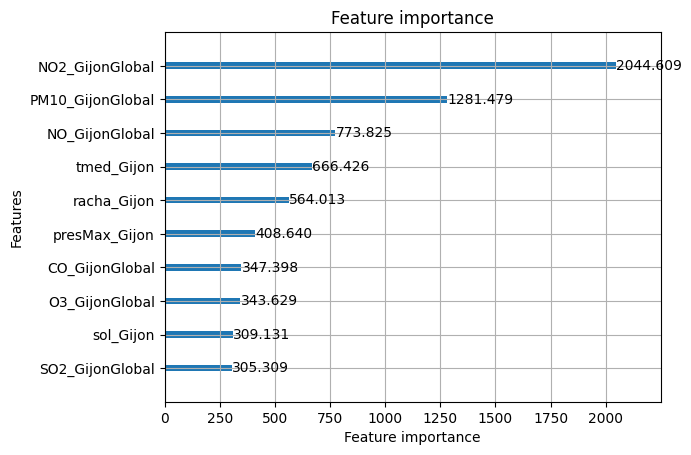

In [20]:

# Prepare dataset
X = merged_df.drop(['date', 'ICA_PM25_target'], axis=1)
y = merged_df['ICA_PM25_target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# LightGBM model
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    importance_type='gain',
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    class_weight='balanced'
)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 41],
    'max_depth': [10, 20]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_lgbm = grid_search.best_estimator_

# Evaluation
y_pred = best_lgbm.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, best_lgbm.predict_proba(X_test)[:, 1]))

# Feature Importance Visualization
lgb.plot_importance(best_lgbm, max_num_features=10, importance_type='gain')
plt.show()

In [21]:
# Preparing for final predictions
x_final_prediction = merged_df[merged_df['date'] >= '2023-12-01']
x_final_prediction_scaled = scaler.transform(x_final_prediction.drop(['date', 'ICA_PM25_target'], axis=1))
# final_predictions = best_lgbm.predict(x_final_prediction_scaled)

# # Saving final predictions
# x_final_prediction['prediction'] = final_predictions
# x_final_prediction[['date', 'prediction']].to_csv('final_predictions_december_2023.csv', index=False)

# x_final_prediction[['date', 'prediction']]

# Predicting probabilities for the final predictions
final_predictions_probs = best_lgbm.predict_proba(x_final_prediction_scaled)[:, 1]
final_predictions_probs

array([0.03051709, 0.05470462, 0.05470462, 0.04259737, 0.05470462,
       0.06099804, 0.12575984, 0.05470462, 0.04902078, 0.04827039,
       0.04405066, 0.05155943, 0.04060003, 0.05470462, 0.05470462,
       0.06781873, 0.05470462, 0.05470462, 0.05155943, 0.05470462,
       0.05470462, 0.05470462, 0.05470462, 0.06781873, 0.18462613,
       0.03381215, 0.04767781, 0.05470462, 0.05470462, 0.05470462,
       0.0482739 ])

In [22]:
# Define a custom threshold
custom_threshold = 0.1  # This is an example threshold. Adjust according to your needs.

# Apply custom threshold to probabilities to make final predictions
final_predictions_custom_threshold = (final_predictions_probs >= custom_threshold).astype(int)

# Saving final predictions with custom threshold applied
x_final_prediction['prediction_custom_threshold'] = final_predictions_custom_threshold
x_final_prediction[['date', 'prediction_custom_threshold']].to_csv('final_predictions_custom_threshold_december_2023.csv', index=False)

x_final_prediction[['date', 'prediction_custom_threshold']]

# Convert the predictions into a list
predictions_list = final_predictions_custom_threshold.tolist()

# Convert list to string with commas
predictions_string = ','.join(map(str, predictions_list))

predictions_string


C:\Users\Daniel\AppData\Local\Temp\ipykernel_23648\2753491936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_final_prediction['prediction_custom_threshold'] = final_predictions_custom_threshold


'0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0'